In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Define the Fully Connected Autoencoder
class FCAutoencoder(nn.Module):
    def __init__(self):
        super(FCAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Linear(64, 32),
            nn.Sigmoid()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Sigmoid(),
            nn.Linear(64, 128),
            nn.Sigmoid(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # To normalize the output to [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [7]:
# Hyperparameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 20

# Transform: Normalize and Flatten Images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load MNIST Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# Model, Loss Function, Optimizer
model = FCAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        if epoch != 0:
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model
# torch.save(model.state_dict(), "model/fc_autoencoder.pth")

Epoch [0/20], Loss: 0.2333
Epoch [1/20], Loss: 0.0684
Epoch [2/20], Loss: 0.0598
Epoch [3/20], Loss: 0.0528
Epoch [4/20], Loss: 0.0453
Epoch [5/20], Loss: 0.0414
Epoch [6/20], Loss: 0.0391
Epoch [7/20], Loss: 0.0375
Epoch [8/20], Loss: 0.0364
Epoch [9/20], Loss: 0.0354
Epoch [10/20], Loss: 0.0343
Epoch [11/20], Loss: 0.0332
Epoch [12/20], Loss: 0.0320
Epoch [13/20], Loss: 0.0309
Epoch [14/20], Loss: 0.0299
Epoch [15/20], Loss: 0.0291
Epoch [16/20], Loss: 0.0283
Epoch [17/20], Loss: 0.0276
Epoch [18/20], Loss: 0.0270
Epoch [19/20], Loss: 0.0265


In [10]:
# eval on test set
model.eval()
test_loss = 0.0
for images, _ in test_loader:
    images = images.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, images)

    test_loss += loss.item()

avg_loss = test_loss / len(test_loader)
print(f"Test set, Loss: {avg_loss:.4f}")

# Save the model
# torch.save(model.state_dict(), "model/fc_autoencoder.pth")

Test set, Loss: 0.0263


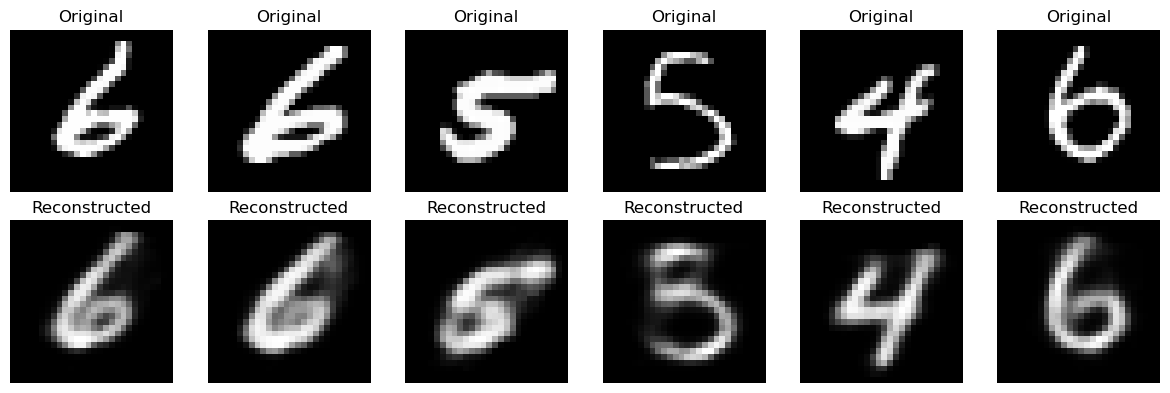

In [11]:
# Example: Load the model and test
model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        break

images = images.cpu()
outputs = outputs.cpu()

fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for i in range(6):
    # Original images
    axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

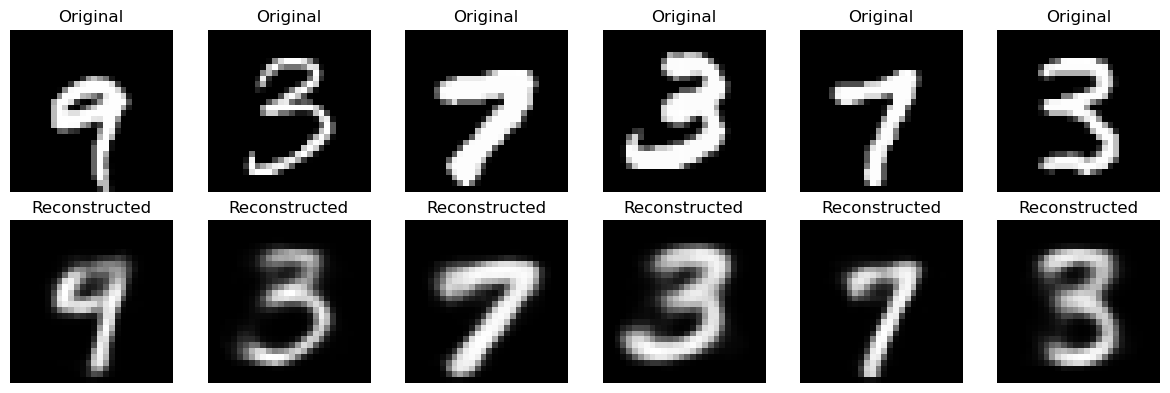

In [12]:
# Example: Load the model and test
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        break

images = images.cpu()
outputs = outputs.cpu()

fig, axes = plt.subplots(2, 6, figsize=(12, 4))
for i in range(6):
    # Original images
    axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
train_encoded = []
train_labels = []

with torch.no_grad():
    for images, targets in train_loader:
        images = images.to(device)
        encoded_vectors = model.encoder(images)  # Get latent representation
        train_encoded.append(encoded_vectors)
        train_labels.append(targets)

# Concatenate all encoded vectors and labels into tensors
train_encoded = torch.cat(train_encoded, dim=0)  # Shape: [num_samples, latent_dim]
train_labels = torch.cat(train_labels, dim=0)  # Shape: [num_samples]

test_encoded = []
test_labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        encoded_vectors = model.encoder(images)  # Get latent representation
        test_encoded.append(encoded_vectors)
        test_labels.append(targets)

# Concatenate all encoded vectors and labels into tensors
test_encoded = torch.cat(test_encoded, dim=0)  # Shape: [num_samples, latent_dim]
test_labels = torch.cat(test_labels, dim=0)  # Shape: [num_samples]

In [14]:
# Step 4: Define the Linear Classification Model
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# Initialize the linear classifier
latent_dim = train_encoded.shape[1]  # Dimension of the latent representation
num_classes = 10  # Number of MNIST classes
classifier = LinearClassifier(latent_dim, num_classes).to(device)


In [ ]:
# Step 5: Train the Linear Classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
num_epochs = 25

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, len(train_encoded), 64):  # Batch processing
        batch_data = train_encoded[i:i+64].to(device)  # Encoded vectors
        batch_labels = train_labels[i:i+64].to(device)      # Corresponding labels

        # Forward pass
        outputs = classifier(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.max(outputs.data, 1)[1]
        total += len(batch_labels)
        correct += (predicted == batch_labels).sum()

    avg_loss = running_loss / (len(train_encoded) // 64)
    accuracy = 100 * correct / float(total)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy}%")


Epoch [1/100], Loss: 0.7104, Accuracy: 81.16999816894531%
Epoch [2/100], Loss: 0.4630, Accuracy: 85.59333801269531%
Epoch [3/100], Loss: 0.4326, Accuracy: 86.35333251953125%
Epoch [4/100], Loss: 0.4182, Accuracy: 86.73333740234375%
Epoch [5/100], Loss: 0.4089, Accuracy: 87.07167053222656%
Epoch [6/100], Loss: 0.4019, Accuracy: 87.29166412353516%
Epoch [7/100], Loss: 0.3964, Accuracy: 87.43000030517578%
Epoch [8/100], Loss: 0.3917, Accuracy: 87.62333679199219%
Epoch [9/100], Loss: 0.3878, Accuracy: 87.73500061035156%
Epoch [10/100], Loss: 0.3843, Accuracy: 87.84833526611328%
Epoch [11/100], Loss: 0.3813, Accuracy: 87.93000030517578%
Epoch [12/100], Loss: 0.3786, Accuracy: 88.00833129882812%
Epoch [13/100], Loss: 0.3761, Accuracy: 88.08833312988281%
Epoch [14/100], Loss: 0.3739, Accuracy: 88.1433334350586%
Epoch [15/100], Loss: 0.3719, Accuracy: 88.18000030517578%
Epoch [16/100], Loss: 0.3700, Accuracy: 88.2249984741211%
Epoch [17/100], Loss: 0.3683, Accuracy: 88.26000213623047%
Epoch [1

In [16]:
# Step 6: Save the trained classifier
# torch.save(classifier.state_dict(), "model/linear_classifier.pth")

In [18]:

# Step 7: Evaluate the Classifier
classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for i in range(0, len(test_encoded), 64):
        batch_data = test_encoded[i:i+64].to(device)
        batch_labels = test_labels[i:i+64].to(device)

        outputs = classifier(batch_data)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the Linear Classifier: {accuracy:.2f}%")

Accuracy of the Linear Classifier: 89.04%
